# Actividad 6: regresiones lineales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Nueva York

In [2]:
cd = pd.read_csv('listings - New York_clean.csv')
# Quitamos el Unamed: 0
cd = cd.drop(['Unnamed: 0'], axis=1)
cd.head()

,id,host_id,beds,bedrooms,source,name,description,neighborhood_overview,host_name,host_since,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,2595,2845,1.0,0.0,city scrape,Skylit Midtown Castle Sanctuary,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,2008-09-09,...,0.0,0.0,4.68,4.73,4.63,4.77,4.80,4.81,4.40,0.27
1,6848,15991,1.0,2.0,city scrape,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,No neighborhood_overview,Allen & Irina,2009-05-06,...,0.3,0.0,4.58,4.59,4.85,4.85,4.80,4.69,4.58,1.04
2,6872,16104,1.0,1.0,city scrape,Uptown Sanctuary w/ Private Bath (Month to Month),This charming distancing-friendly month-to-mon...,This sweet Harlem sanctuary is a 10-20 minute ...,Kae,2009-05-07,...,0.0,0.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.03
3,6990,16800,1.0,1.0,city scrape,UES Beautiful Blue Room,Beautiful peaceful healthy home,"Location: Five minutes to Central Park, Museum...",Cyn,2009-05-12,...,0.3,0.0,4.88,4.83,4.95,4.96,4.95,4.85,4.85,1.37
4,7064,17297,1.0,1.0,previous scrape,"Amazing location! Wburg. Large, bright & tranquil","Large, private loft-like room in a spacious 2-...","- One stop from the East Village, Lower East S...",Joelle,2009-05-15,...,0.0,0.0,4.91,5.00,4.91,5.00,5.00,5.00,5.00,0.08


In [3]:
# Transformamos algunas variables para su tratamiento

# Transformamos host_response_rate a float
# Los No data los quitamos
cd = cd[cd['host_acceptance_rate'] != 'No data']
cd['host_acceptance_rate'] = cd['host_acceptance_rate'].str.replace('%', '').astype(float)

# Pasamos host_is_superhost a entero, donde t es 1 y f es 0
cd['host_is_superhost'] = cd['host_is_superhost'].replace({'t': 1, 'f': 0})
cd['host_is_superhost'] = cd['host_is_superhost'].astype(int)

# Dado que no tenemos la variable bathrooms, la creamos usando bathrooms_text
# Quitaremos el texto y nos quedaremos solo con el número de la izquierda
cd['bathrooms'] = cd['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
# Quitamos los valores nulos
cd = cd[cd['bathrooms'].notnull()]

# Transformamos las variable instant_bookable a entero, donde t es 1 y f es 0
cd['instant_bookable'] = cd['instant_bookable'].replace({'t': 1, 'f': 0})

# Transformamos la variable host_identity_verified a entero, donde t es 1 y f es 0
cd['host_identity_verified'] = cd['host_identity_verified'].replace({'t': 1, 'f': 0})

# Pasamos a numérico la variable property_type
# Donde:
types = {
    'Entire rental unit': 1,
    'Private room in rental unit': 3,
    'Private room in home': 4,
    'Room in hotel': 2,
    'Private room in townhouse': 5,
    'Entire home': 6
    }
cd['property_type'] = cd['property_type'].replace(types)

C:\Users\angel\AppData\Local\Temp\ipykernel_5436\2816372348.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cd['host_is_superhost'] = cd['host_is_superhost'].replace({'t': 1, 'f': 0})
C:\Users\angel\AppData\Local\Temp\ipykernel_5436\2816372348.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cd['instant_bookable'] = cd['instant_bookable'].replace({'t': 1, 'f': 0})
C:\Users\angel\AppData\Local\Temp\ipykernel_5436\2816372348.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future

In [4]:
# Vamos a separar en distintos dataframes los diferentes tipos de habitaciones
cd_entire = cd[cd['room_type'] == 'Entire home/apt']
cd_private = cd[cd['room_type'] == 'Private room']
cd_shared = cd[cd['room_type'] == 'Shared room']
cd_hotel = cd[cd['room_type'] == 'Hotel room']

print(cd_entire['room_type'].value_counts(), end='\n\n')
print(cd_private['room_type'].value_counts(), end='\n\n')
print(cd_shared['room_type'].value_counts(), end='\n\n')
print(cd_hotel['room_type'].value_counts(), end='\n\n')

room_type
Entire home/apt    12205
Name: count, dtype: int64

room_type
Private room    9623
Name: count, dtype: int64

room_type
Shared room    186
Name: count, dtype: int64

room_type
Hotel room    511
Name: count, dtype: int64



### x = host_acceptance_rate, y = price

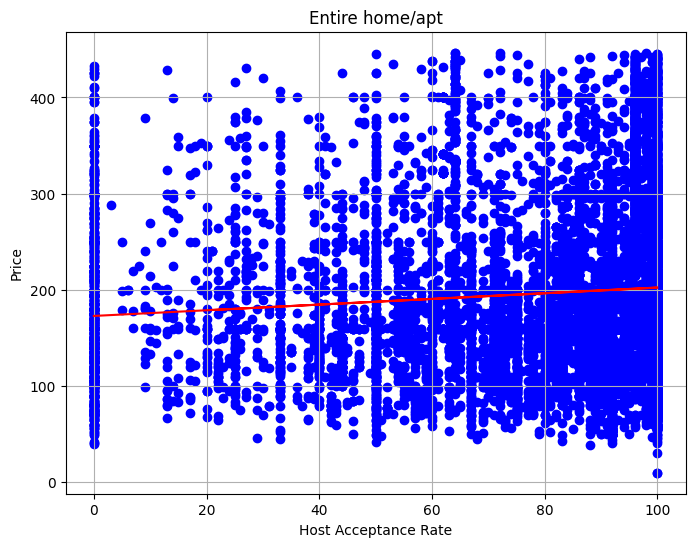

In [5]:
# Ahora, vamos a realizar una regresión lineal usando cada df de habitaciones con respecto al precio y host_acceptance_rate.
# Ponemos el precio como variable dependiente y el host_acceptance_rate como variable independiente.

model = LinearRegression()
model.fit(cd_entire[['host_acceptance_rate']], cd_entire['price'])

# Hacemos la gráfica de la regresión lineal
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['host_acceptance_rate']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['host_acceptance_rate']], model.predict(cd_entire[['host_acceptance_rate']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [6]:
# Sacamos los parámetros de la regresión lineal con su puntaje
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['host_acceptance_rate']], cd_entire['price']))

Pendiente: [0.29493639]
Intercepto: 172.9425121954105
y = 0.2949363912914712x + 172.9425121954105

Puntaje del modelo: 0.008954866023994423


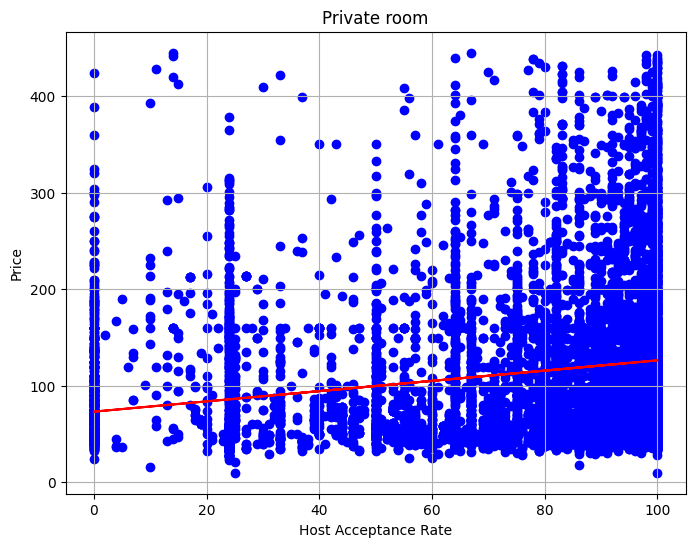

In [7]:
# Haremos lo mismo para los otros tipos de habitaciones
model = LinearRegression()
model.fit(cd_private[['host_acceptance_rate']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['host_acceptance_rate']], cd_private['price'], color='blue')
plt.plot(cd_private[['host_acceptance_rate']], model.predict(cd_private[['host_acceptance_rate']]), color='red')
plt.title('Private room')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [8]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['host_acceptance_rate']], cd_private['price']))

Pendiente: [0.53122942]
Intercepto: 73.26018155777197
y = 0.5312294212571803x + 73.26018155777197

Puntaje del modelo: 0.039417987610363414


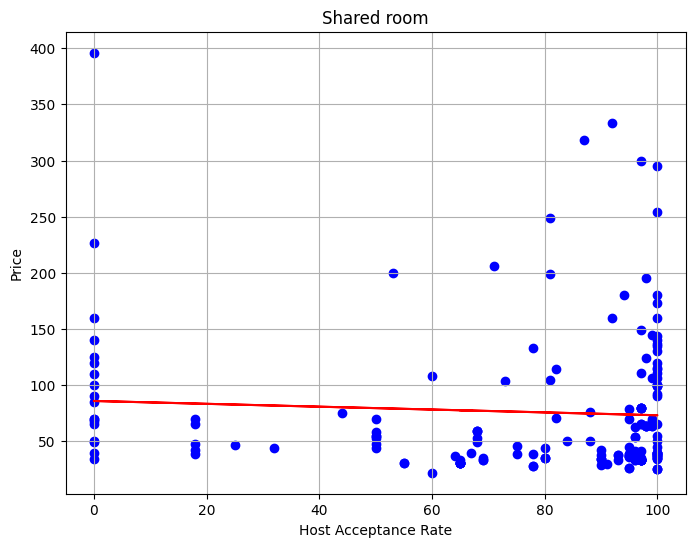

In [9]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['host_acceptance_rate']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['host_acceptance_rate']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['host_acceptance_rate']], model.predict(cd_shared[['host_acceptance_rate']]), color='red')
plt.title('Shared room')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [10]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['host_acceptance_rate']], cd_shared['price']))

Pendiente: [-0.12728277]
Intercepto: 85.89733156896064
y = -0.12728277150359738x + 85.89733156896064

Puntaje del modelo: 0.0040635236586586965


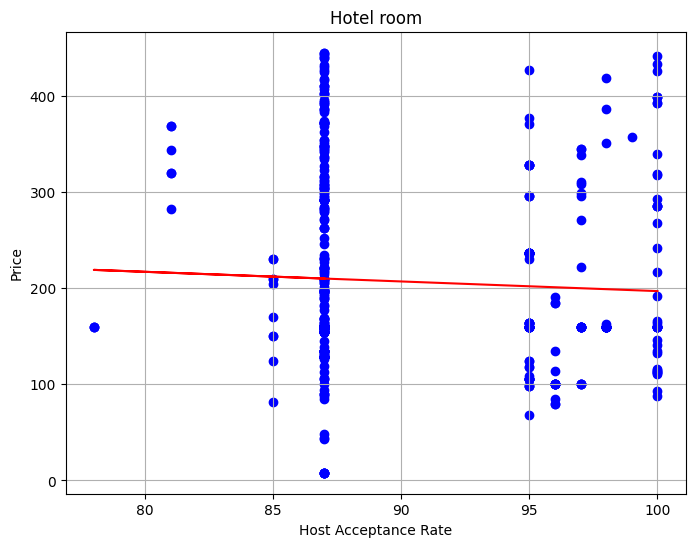

In [11]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['host_acceptance_rate']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['host_acceptance_rate']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['host_acceptance_rate']], model.predict(cd_hotel[['host_acceptance_rate']]), color='red')
plt.title('Hotel room')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [12]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['host_acceptance_rate']], cd_hotel['price']))

Pendiente: [-1.00385759]
Intercepto: 297.3573015759016
y = -1.0038575896452795x + 297.3573015759016

Puntaje del modelo: 0.002883782645606514


### x = host_is_superhost, y = price

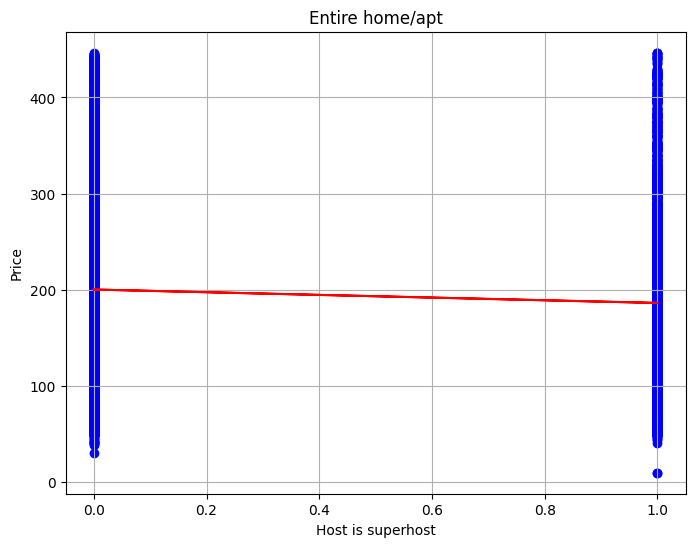

In [13]:
# Ahora, vamos a realizar una regresión lineal usando cada df de habitaciones con respecto al precio y host_is_superhost.

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['host_is_superhost']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['host_is_superhost']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['host_is_superhost']], model.predict(cd_entire[['host_is_superhost']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Host is superhost')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [14]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['host_is_superhost']], cd_entire['price']))

Pendiente: [-13.95244937]
Intercepto: 200.39080918564264
y = -13.95244937494541x + 200.39080918564264

Puntaje del modelo: 0.005347372637710013


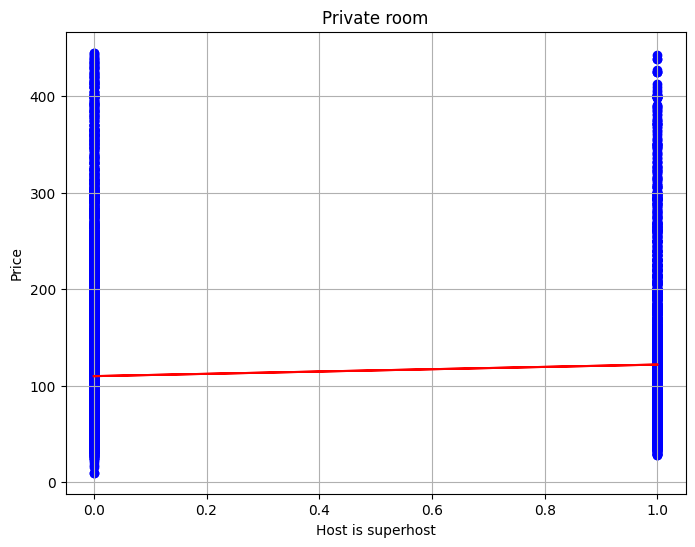

In [15]:
# Private room
model = LinearRegression()
model.fit(cd_private[['host_is_superhost']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['host_is_superhost']], cd_private['price'], color='blue')
plt.plot(cd_private[['host_is_superhost']], model.predict(cd_private[['host_is_superhost']]), color='red')
plt.title('Private room')
plt.xlabel('Host is superhost')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [16]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['host_is_superhost']], cd_private['price']))

Pendiente: [11.97262852]
Intercepto: 110.02381921619865
y = 11.97262851669077x + 110.02381921619865

Puntaje del modelo: 0.004605179224768441


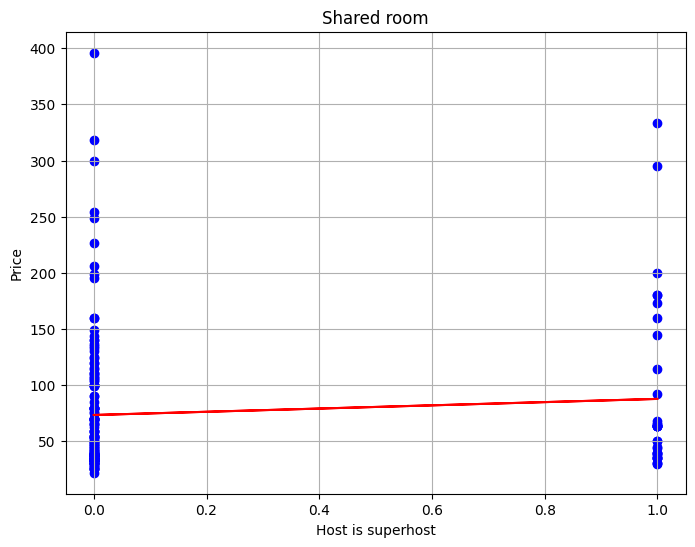

In [17]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['host_is_superhost']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['host_is_superhost']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['host_is_superhost']], model.predict(cd_shared[['host_is_superhost']]), color='red')
plt.title('Shared room')
plt.xlabel('Host is superhost')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [18]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['host_is_superhost']], cd_shared['price']))

Pendiente: [14.33620467]
y = 14.336204667297391x + 73.40093818984548

Puntaje del modelo: 0.007873190457873935


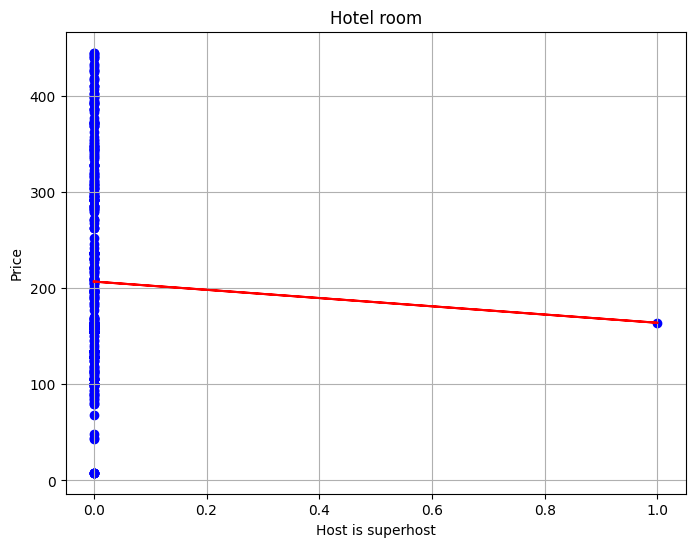

In [19]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['host_is_superhost']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['host_is_superhost']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['host_is_superhost']], model.predict(cd_hotel[['host_is_superhost']]), color='red')
plt.title('Hotel room')
plt.xlabel('Host is superhost')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [20]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['host_is_superhost']], cd_hotel['price']))

Pendiente: [-42.89761725]
Intercepto: 206.897617252029
y = -42.89761725202832x + 206.897617252029

Puntaje del modelo: 0.00040094354826569756


### x = bathrooms, y = accomodates

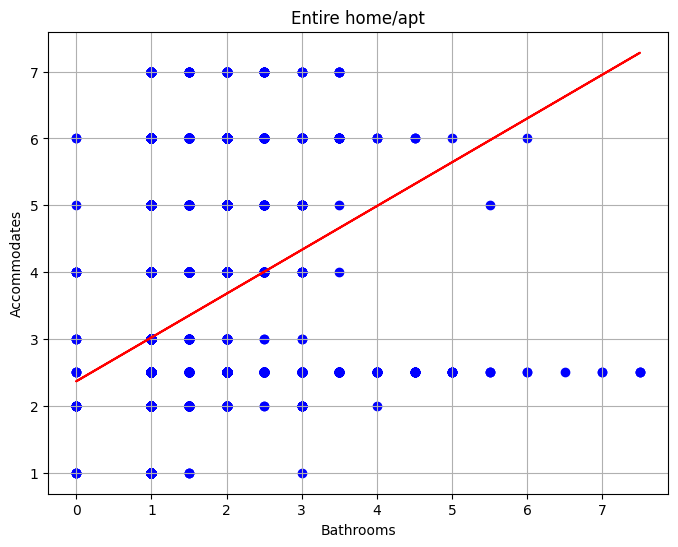

In [21]:
# Ahora, vamos a realizar una regresión lineal usando cada df de habitaciones con respecto al accoomodates y bathrooms.
# Ponemos los baños como variable independiente y el número de acomodados como variable dependiente.

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['bathrooms']], cd_entire['accommodates'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['bathrooms']], cd_entire['accommodates'], color='blue')
plt.plot(cd_entire[['bathrooms']], model.predict(cd_entire[['bathrooms']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [22]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['bathrooms']], cd_entire['accommodates']))

Pendiente: [0.65514385]
Intercepto: 2.3680616084180857
y = 0.6551438523602033x + 2.3680616084180857

Puntaje del modelo: 0.05886849064313193


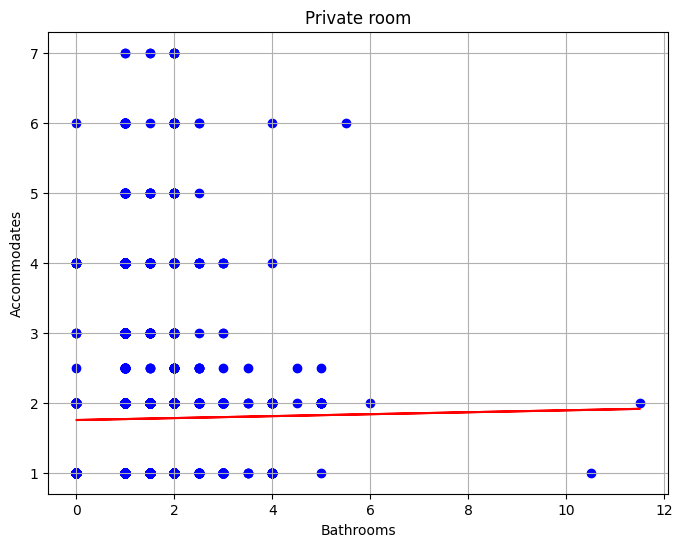

In [23]:
# Private room
model = LinearRegression()
model.fit(cd_private[['bathrooms']], cd_private['accommodates'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['bathrooms']], cd_private['accommodates'], color='blue')
plt.plot(cd_private[['bathrooms']], model.predict(cd_private[['bathrooms']]), color='red')
plt.title('Private room')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [24]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['bathrooms']], cd_private['accommodates']))

Pendiente: [0.01389936]
Intercepto: 1.7527571898243561
y = 0.013899361441146998x + 1.7527571898243561

Puntaje del modelo: 9.465814853293342e-05


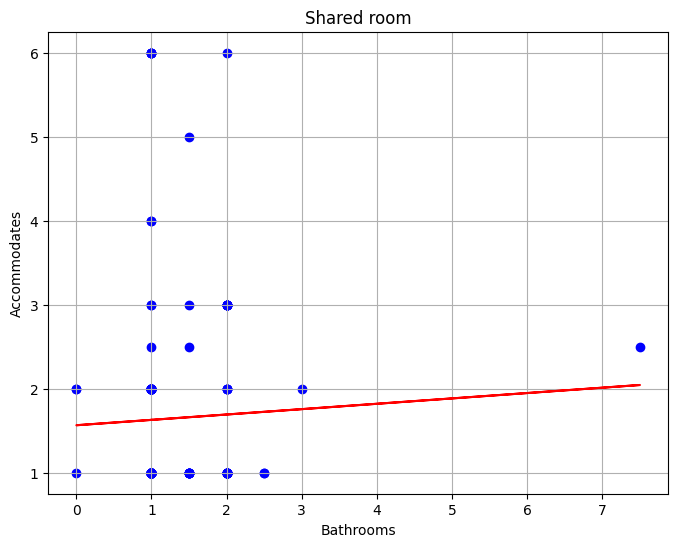

In [25]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['bathrooms']], cd_shared['accommodates'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['bathrooms']], cd_shared['accommodates'], color='blue')
plt.plot(cd_shared[['bathrooms']], model.predict(cd_shared[['bathrooms']]), color='red')
plt.title('Shared room')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [26]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['bathrooms']], cd_shared['accommodates']))

Pendiente: [0.06387975]
Intercepto: 1.5652522613397715
y = 0.06387974798670486x + 1.5652522613397715

Puntaje del modelo: 0.0015594801877728548


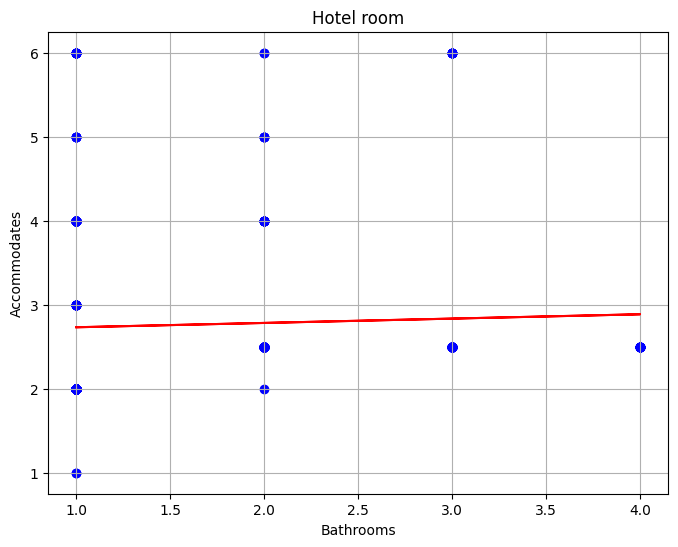

In [27]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['bathrooms']], cd_hotel['accommodates'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['bathrooms']], cd_hotel['accommodates'], color='blue')
plt.plot(cd_hotel[['bathrooms']], model.predict(cd_hotel[['bathrooms']]), color='red')
plt.title('Hotel room')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [28]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['bathrooms']], cd_hotel['accommodates']))

Pendiente: [0.05153506]
Intercepto: 2.680056340414717
y = 0.05153506449494823x + 2.680056340414717

Puntaje del modelo: 0.001678120398136529


### x = review_score_cleanliness, y = price

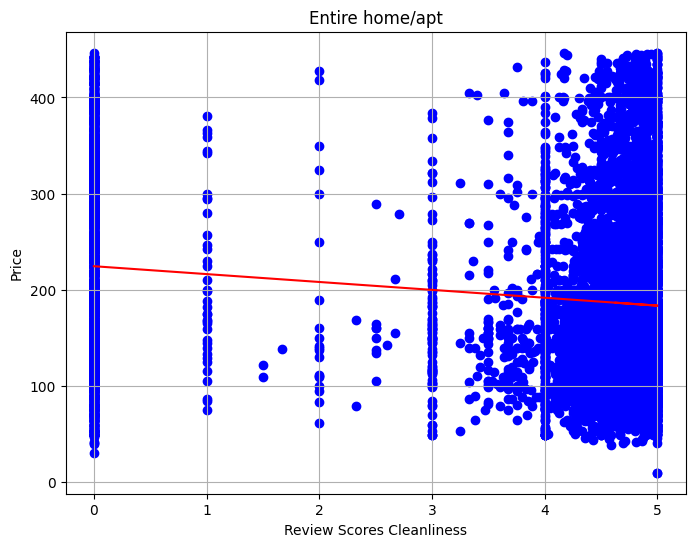

In [29]:
# Seguimos, pero ahora con review_score_cleanliness y price

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['review_scores_cleanliness']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['review_scores_cleanliness']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['review_scores_cleanliness']], model.predict(cd_entire[['review_scores_cleanliness']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [30]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['review_scores_cleanliness']], cd_entire['price']))

Pendiente: [-8.19444077]
y = -8.19444077170333x + 224.62641535222764

Puntaje del modelo: 0.036890446671605015


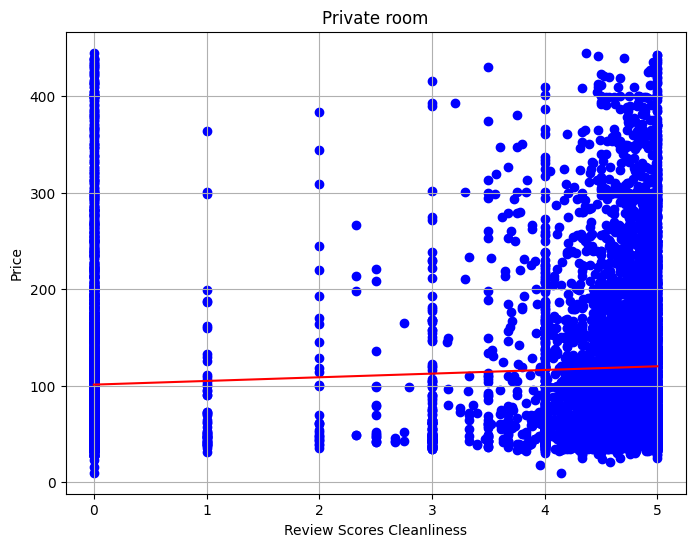

In [31]:
# Private room
model = LinearRegression()
model.fit(cd_private[['review_scores_cleanliness']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['review_scores_cleanliness']], cd_private['price'], color='blue')
plt.plot(cd_private[['review_scores_cleanliness']], model.predict(cd_private[['review_scores_cleanliness']]), color='red')
plt.title('Private room')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [32]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['review_scores_cleanliness']], cd_private['price']))

Pendiente: [3.79872271]
y = 3.798722708649531x + 101.24952977188177

Puntaje del modelo: 0.010933617034038279


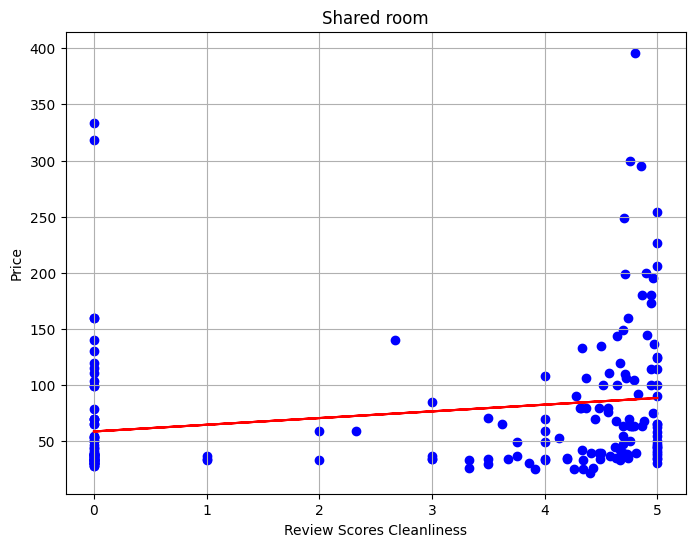

In [33]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['review_scores_cleanliness']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['review_scores_cleanliness']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['review_scores_cleanliness']], model.predict(cd_shared[['review_scores_cleanliness']]), color='red')
plt.title('Shared room')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [34]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['review_scores_cleanliness']], cd_shared['price']))

Pendiente: [5.96462251]
y = 5.964622507142897x + 58.73899418628996

Puntaje del modelo: 0.04187278725115018


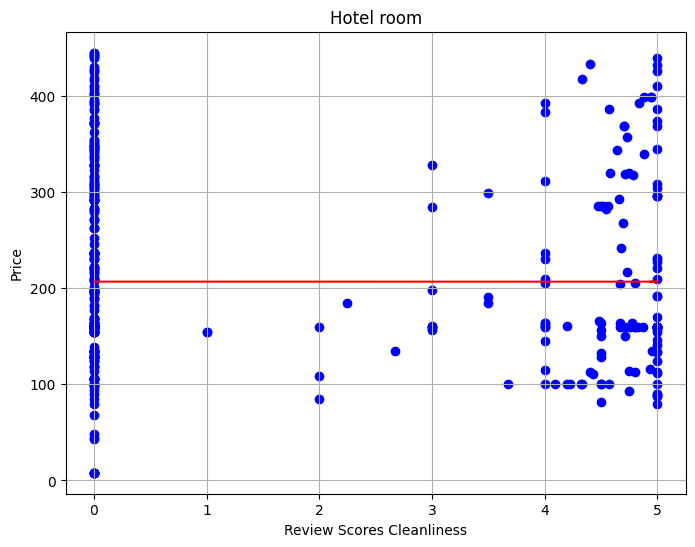

In [35]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['review_scores_cleanliness']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['review_scores_cleanliness']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['review_scores_cleanliness']], model.predict(cd_hotel[['review_scores_cleanliness']]), color='red')
plt.title('Hotel room')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [36]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['review_scores_cleanliness']], cd_hotel['price']))

Pendiente: [-0.00768503]
Intercepto: 206.8240202045682
y = -0.0076850252067501715x + 206.8240202045682

Puntaje del modelo: 2.8937258811367883e-08


### host_idendity_verified, y = price

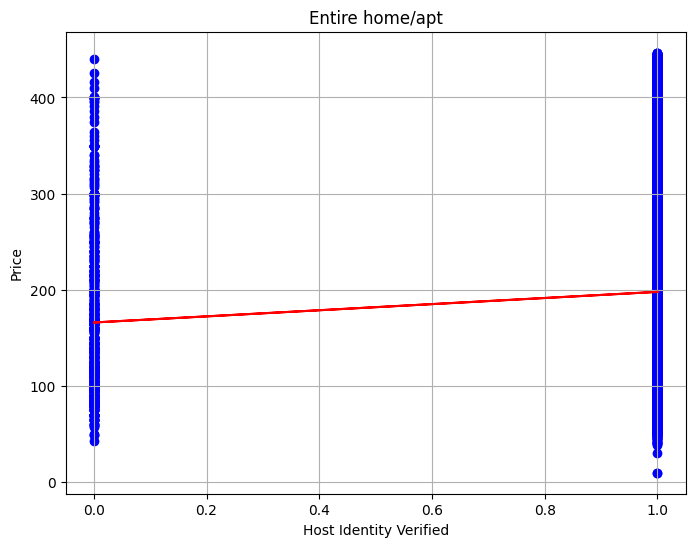

In [37]:
# Seguimos con host_identity_verified como independiente y price como dependiente

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['host_identity_verified']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['host_identity_verified']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['host_identity_verified']], model.predict(cd_entire[['host_identity_verified']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Host Identity Verified')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [38]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['host_identity_verified']], cd_entire['price']))

Pendiente: [31.82439154]
Intercepto: 166.1304829256752
y = 31.82439154451236x + 166.1304829256752

Puntaje del modelo: 0.007596477170287885


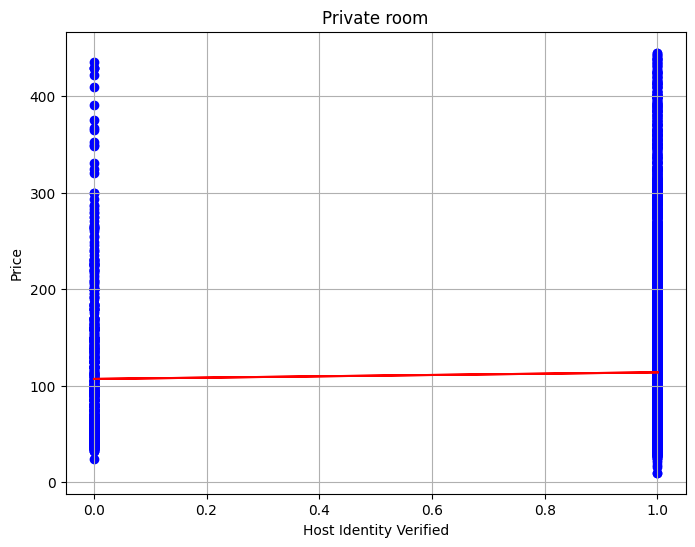

In [39]:
# Private room
model = LinearRegression()
model.fit(cd_private[['host_identity_verified']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['host_identity_verified']], cd_private['price'], color='blue')
plt.plot(cd_private[['host_identity_verified']], model.predict(cd_private[['host_identity_verified']]), color='red')
plt.title('Private room')
plt.xlabel('Host Identity Verified')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [40]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['host_identity_verified']], cd_private['price']))

Pendiente: [6.85068267]
Intercepto: 107.1205583248591
y = 6.850682668744481x + 107.1205583248591

Puntaje del modelo: 0.0005523813720689219


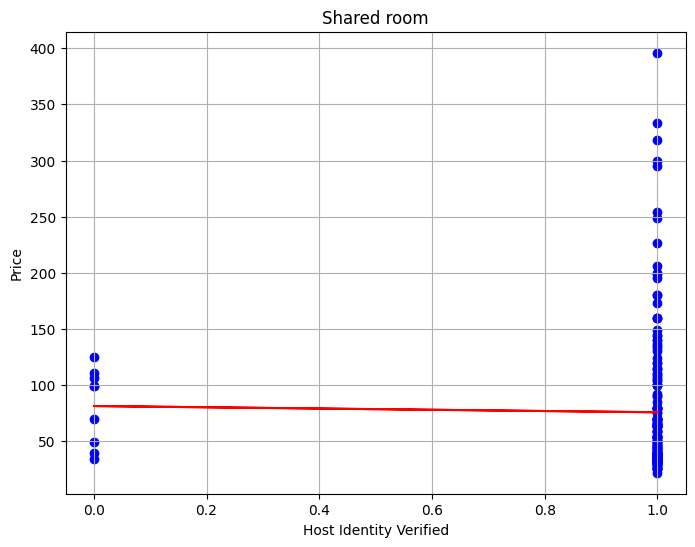

In [41]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['host_identity_verified']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['host_identity_verified']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['host_identity_verified']], model.predict(cd_shared[['host_identity_verified']]), color='red')
plt.title('Shared room')
plt.xlabel('Host Identity Verified')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [42]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['host_identity_verified']], cd_shared['price']))

Pendiente: [-5.55927495]
Intercepto: 81.38888888888889
y = -5.559274952919022x + 81.38888888888889

Puntaje del modelo: 0.00035685309261479503


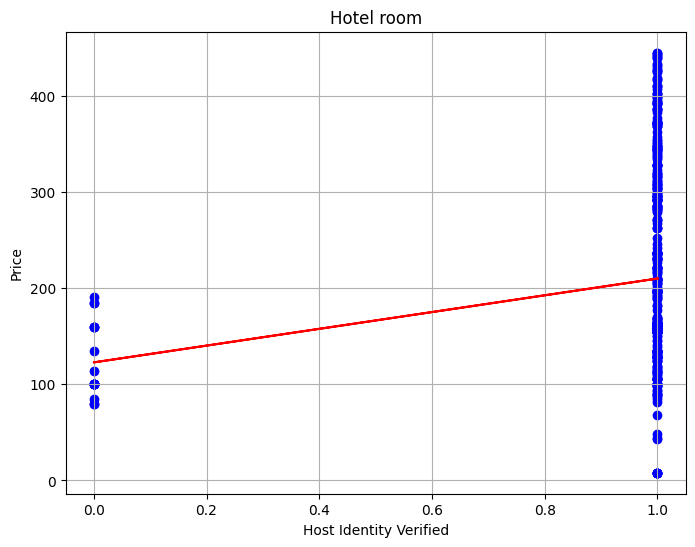

In [43]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['host_identity_verified']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['host_identity_verified']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['host_identity_verified']], model.predict(cd_hotel[['host_identity_verified']]), color='red')
plt.title('Hotel room')
plt.xlabel('Host Identity Verified')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [44]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['host_identity_verified']], cd_hotel['price']))

Pendiente: [87.24716636]
Intercepto: 122.81052631578933
y = 87.24716636415944x + 122.81052631578933

Puntaje del modelo: 0.030399614661050012


### x = instant_bookable, y = price

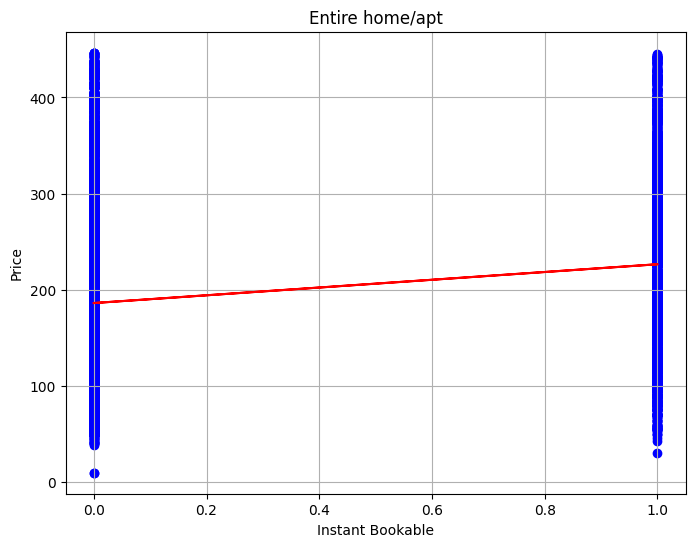

In [45]:
# Seguimos, pero ahora con instant_bookable y price

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['instant_bookable']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['instant_bookable']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['instant_bookable']], model.predict(cd_entire[['instant_bookable']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [46]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['instant_bookable']], cd_entire['price']))

Pendiente: [40.33146226]
Intercepto: 186.33639974776864
y = 40.331462258504786x + 186.33639974776864

Puntaje del modelo: 0.03730869883551502


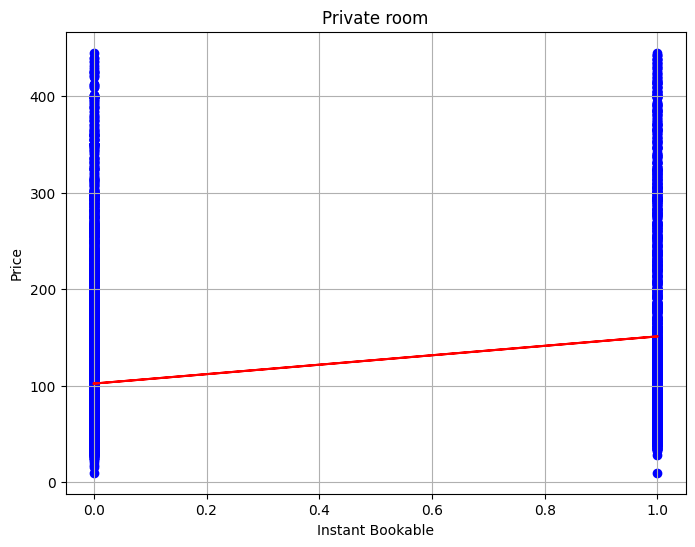

In [47]:
# Private room
model = LinearRegression()
model.fit(cd_private[['instant_bookable']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['instant_bookable']], cd_private['price'], color='blue')
plt.plot(cd_private[['instant_bookable']], model.predict(cd_private[['instant_bookable']]), color='red')
plt.title('Private room')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [48]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['instant_bookable']], cd_private['price']))

Pendiente: [48.88751942]
Intercepto: 102.31625692172528
y = 48.88751941635374x + 102.31625692172528

Puntaje del modelo: 0.06635730647208615


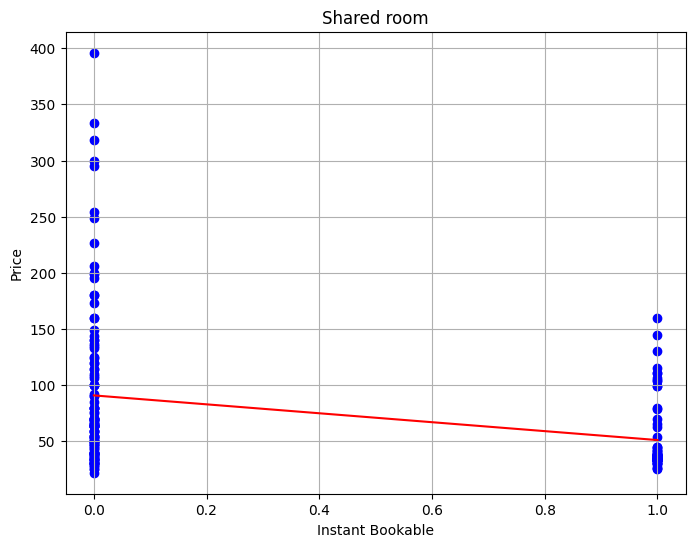

In [49]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['instant_bookable']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['instant_bookable']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['instant_bookable']], model.predict(cd_shared[['instant_bookable']]), color='red')
plt.title('Shared room')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [50]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['instant_bookable']], cd_shared['price']))

Pendiente: [-39.7667255]
Intercepto: 90.85078347578346
y = -39.76672550476896x + 90.85078347578346

Puntaje del modelo: 0.09253627142121013


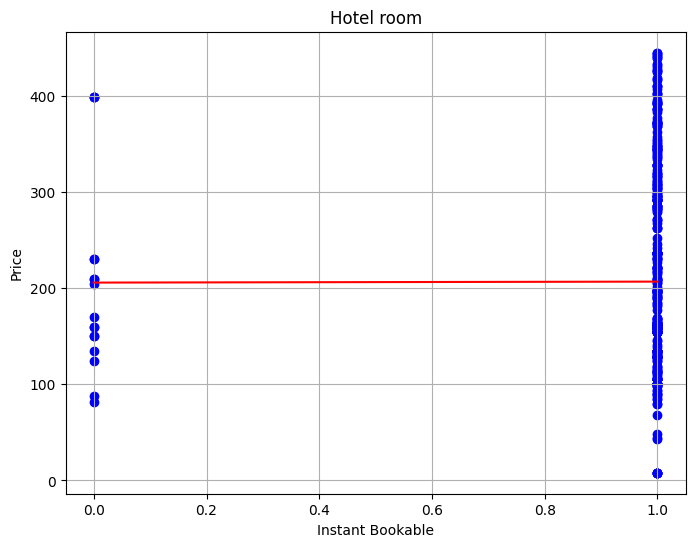

In [51]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['instant_bookable']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['instant_bookable']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['instant_bookable']], model.predict(cd_hotel[['instant_bookable']]), color='red')
plt.title('Hotel room')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [52]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['instant_bookable']], cd_hotel['price']))

Pendiente: [1.02247459]
Intercepto: 205.82521008403344
y = 1.0224745862220828x + 205.82521008403344

Puntaje del modelo: 3.750832137328075e-06


### x = property_type, y = price

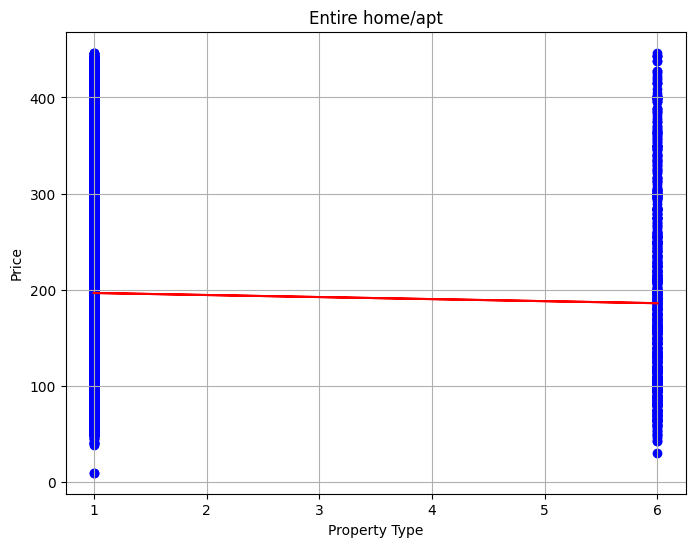

In [53]:
# Hacemos lo mismo, pero ahora con property_type y price

# Entire home/apt
model = LinearRegression()

# Filtramos ny_entire para quitar todos los valores en los que property_type no sea numérico
cd_entire = cd_entire[pd.to_numeric(cd_entire['property_type'], errors='coerce').notnull()]

model.fit(cd_entire[['property_type']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['property_type']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['property_type']], model.predict(cd_entire[['property_type']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [54]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['property_type']], cd_entire['price']))

Pendiente: [-2.12939142]
Intercepto: 198.95020154261414
y = -2.1293914214077865x + 198.95020154261414

Puntaje del modelo: 0.001138568185947042


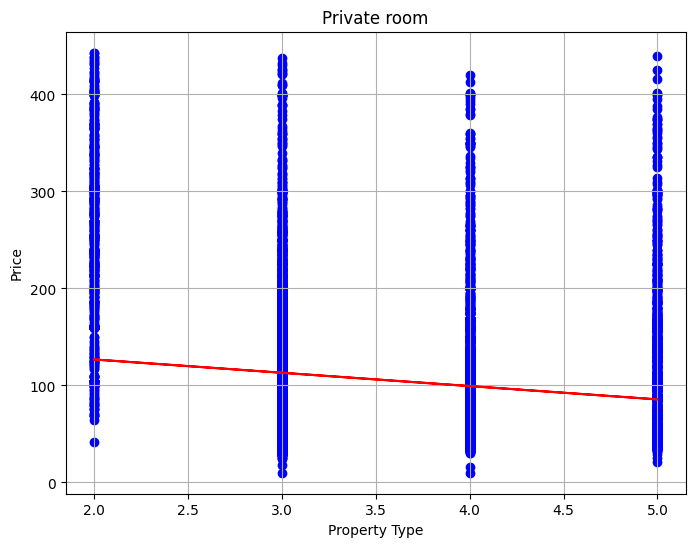

In [55]:
# Private room
model = LinearRegression()
cd_private = cd_private[pd.to_numeric(cd_private['property_type'], errors='coerce').notnull()]
model.fit(cd_private[['property_type']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['property_type']], cd_private['price'], color='blue')
plt.plot(cd_private[['property_type']], model.predict(cd_private[['property_type']]), color='red')
plt.title('Private room')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [56]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['property_type']], cd_private['price']))

Pendiente: [-13.72949639]
Intercepto: 154.25382607059805
y = -13.729496385126778x + 154.25382607059805

Puntaje del modelo: 0.0193051738139981


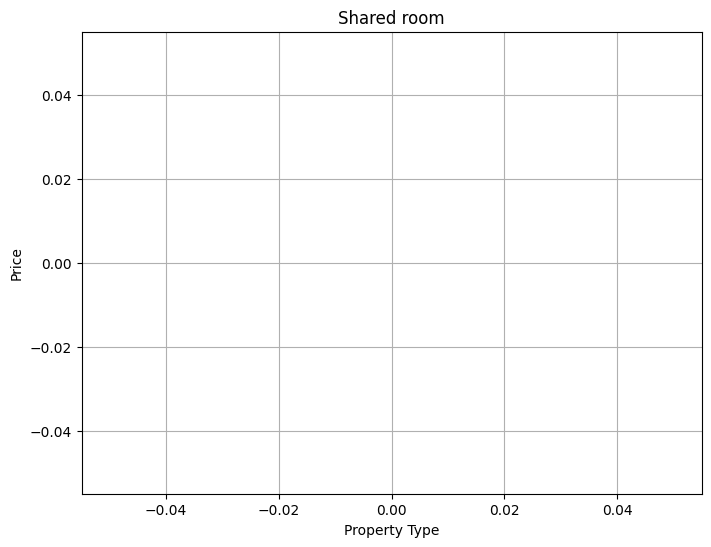

In [57]:
# Shared room
model = LinearRegression()
cd_shared = cd_shared[pd.to_numeric(cd_shared['property_type'], errors='coerce').notnull()]
#model.fit(ny_shared[['property_type']], ny_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['property_type']], cd_shared['price'], color='blue')
#plt.plot(ny_shared[['property_type']], model.predict(ny_shared[['property_type']]), color='red')
plt.title('Shared room')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Paraece que ninguna de las habitaciones compartidas tiene property_type de los 6 más comunes

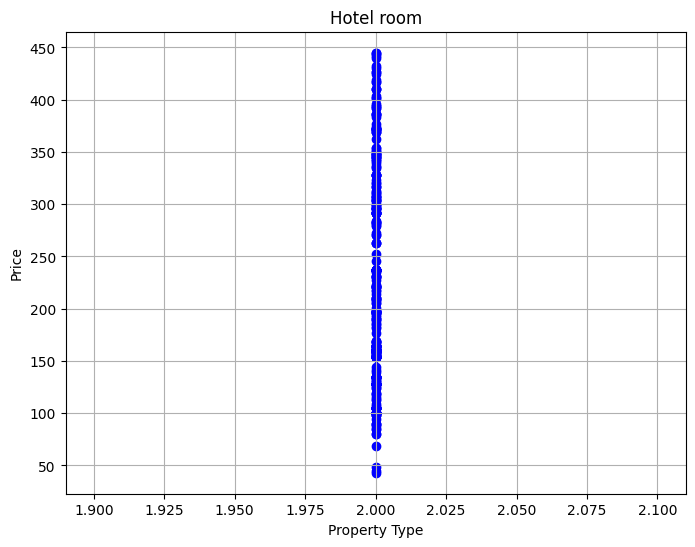

In [58]:
# Hotel room
model = LinearRegression()
cd_hotel = cd_hotel[pd.to_numeric(cd_hotel['property_type'], errors='coerce').notnull()]
#model.fit(cd_hotel[['property_type']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['property_type']], cd_hotel['price'], color='blue')
#plt.plot(cd_hotel[['property_type']], model.predict(cd_hotel[['property_type']]), color='red')
plt.title('Hotel room')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()
# Parece que ninguna de las habitaciones tiene un tipo de propiedad de las 6 más comunes

In [59]:
# Obtenemos los parámetros
# m = model.coef_
# b = model.intercept_
# print('Pendiente:', m)
# print('Intercepto:', b)

# # Entonces, el modelo lineal sería:
# print(f'y = {m[0]}x + {b}', end='\n\n')

# print('Puntaje del modelo:', model.score(ny_hotel[['property_type']], ny_hotel['price']))

## CDMX

In [60]:
cd = pd.read_csv('listings - New York_clean.csv')
# Quitamos el Unamed: 0
cd = cd.drop(['Unnamed: 0'], axis=1)
cd.head()

,id,host_id,beds,bedrooms,source,name,description,neighborhood_overview,host_name,host_since,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,2595,2845,1.0,0.0,city scrape,Skylit Midtown Castle Sanctuary,"Beautiful, spacious skylit studio in the heart...",Centrally located in the heart of Manhattan ju...,Jennifer,2008-09-09,...,0.0,0.0,4.68,4.73,4.63,4.77,4.80,4.81,4.40,0.27
1,6848,15991,1.0,2.0,city scrape,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,No neighborhood_overview,Allen & Irina,2009-05-06,...,0.3,0.0,4.58,4.59,4.85,4.85,4.80,4.69,4.58,1.04
2,6872,16104,1.0,1.0,city scrape,Uptown Sanctuary w/ Private Bath (Month to Month),This charming distancing-friendly month-to-mon...,This sweet Harlem sanctuary is a 10-20 minute ...,Kae,2009-05-07,...,0.0,0.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,0.03
3,6990,16800,1.0,1.0,city scrape,UES Beautiful Blue Room,Beautiful peaceful healthy home,"Location: Five minutes to Central Park, Museum...",Cyn,2009-05-12,...,0.3,0.0,4.88,4.83,4.95,4.96,4.95,4.85,4.85,1.37
4,7064,17297,1.0,1.0,previous scrape,"Amazing location! Wburg. Large, bright & tranquil","Large, private loft-like room in a spacious 2-...","- One stop from the East Village, Lower East S...",Joelle,2009-05-15,...,0.0,0.0,4.91,5.00,4.91,5.00,5.00,5.00,5.00,0.08


In [61]:
# Transformamos algunas variables para su tratamiento

# Transformamos host_response_rate a float
# Los No data los quitamos
cd = cd[cd['host_acceptance_rate'] != 'No data']
cd['host_acceptance_rate'] = cd['host_acceptance_rate'].str.replace('%', '').astype(float)

# Pasamos host_is_superhost a entero, donde t es 1 y f es 0
cd['host_is_superhost'] = cd['host_is_superhost'].replace({'t': 1, 'f': 0})
cd['host_is_superhost'] = cd['host_is_superhost'].astype(int)

# Dado que no tenemos la variable bathrooms, la creamos usando bathrooms_text
# Quitaremos el texto y nos quedaremos solo con el número de la izquierda
cd['bathrooms'] = cd['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
# Quitamos los valores nulos
cd = cd[cd['bathrooms'].notnull()]

# Transformamos las variable instant_bookable a entero, donde t es 1 y f es 0
cd['instant_bookable'] = cd['instant_bookable'].replace({'t': 1, 'f': 0})

# Transformamos la variable host_identity_verified a entero, donde t es 1 y f es 0
cd['host_identity_verified'] = cd['host_identity_verified'].replace({'t': 1, 'f': 0})

# Pasamos a numérico la variable property_type
# Donde:
types = {
    'Entire rental unit': 1,
    'Entire condo': 2,
    'Private room in rental unit': 3,
    'Private room in home': 4,
    'Entire loft': 5,
    'Entire serviced apartment': 6
    }
cd['property_type'] = cd['property_type'].replace(types)

C:\Users\angel\AppData\Local\Temp\ipykernel_5436\2173676331.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cd['host_is_superhost'] = cd['host_is_superhost'].replace({'t': 1, 'f': 0})
C:\Users\angel\AppData\Local\Temp\ipykernel_5436\2173676331.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cd['instant_bookable'] = cd['instant_bookable'].replace({'t': 1, 'f': 0})
C:\Users\angel\AppData\Local\Temp\ipykernel_5436\2173676331.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future

In [62]:
# Vamos a separar en distintos dataframes los diferentes tipos de habitaciones
cd_entire = cd[cd['room_type'] == 'Entire home/apt']
cd_private = cd[cd['room_type'] == 'Private room']
cd_shared = cd[cd['room_type'] == 'Shared room']
cd_hotel = cd[cd['room_type'] == 'Hotel room']

print(cd_entire['room_type'].value_counts(), end='\n\n')
print(cd_private['room_type'].value_counts(), end='\n\n')
print(cd_shared['room_type'].value_counts(), end='\n\n')
print(cd_hotel['room_type'].value_counts(), end='\n\n')

room_type
Entire home/apt    12205
Name: count, dtype: int64

room_type
Private room    9623
Name: count, dtype: int64

room_type
Shared room    186
Name: count, dtype: int64

room_type
Hotel room    511
Name: count, dtype: int64



### x = host_acceptance_rate, y = price

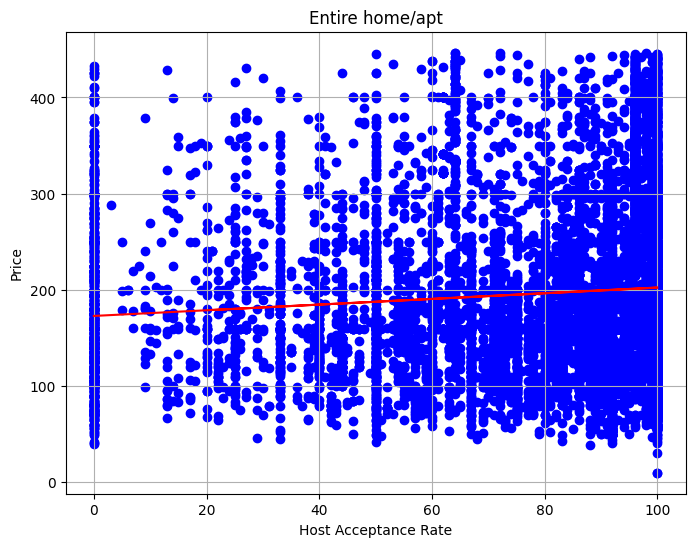

In [63]:
# Ahora, vamos a realizar una regresión lineal usando cada df de habitaciones con respecto al precio y host_acceptance_rate.
# Ponemos el precio como variable dependiente y el host_acceptance_rate como variable independiente.

model = LinearRegression()
model.fit(cd_entire[['host_acceptance_rate']], cd_entire['price'])

# Hacemos la gráfica de la regresión lineal
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['host_acceptance_rate']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['host_acceptance_rate']], model.predict(cd_entire[['host_acceptance_rate']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [64]:
# Sacamos los parámetros de la regresión lineal con su puntaje
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['host_acceptance_rate']], cd_entire['price']))

Pendiente: [0.29493639]
Intercepto: 172.9425121954105
y = 0.2949363912914712x + 172.9425121954105

Puntaje del modelo: 0.008954866023994423


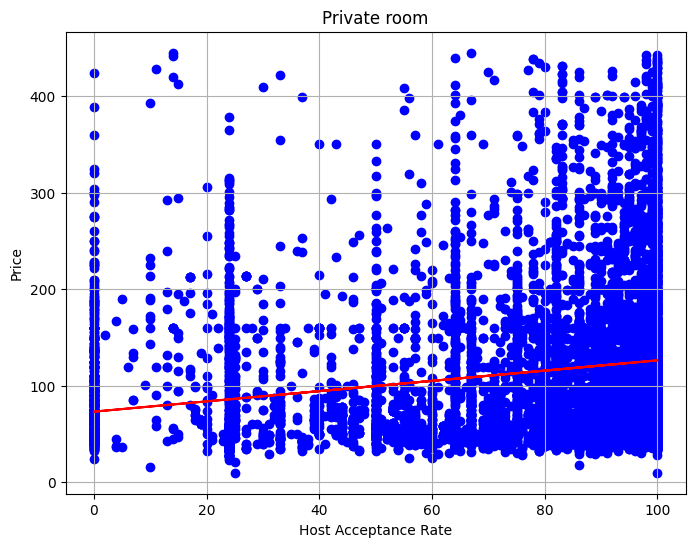

In [65]:
# Haremos lo mismo para los otros tipos de habitaciones
model = LinearRegression()
model.fit(cd_private[['host_acceptance_rate']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['host_acceptance_rate']], cd_private['price'], color='blue')
plt.plot(cd_private[['host_acceptance_rate']], model.predict(cd_private[['host_acceptance_rate']]), color='red')
plt.title('Private room')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [66]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['host_acceptance_rate']], cd_private['price']))

Pendiente: [0.53122942]
Intercepto: 73.26018155777197
y = 0.5312294212571803x + 73.26018155777197

Puntaje del modelo: 0.039417987610363414


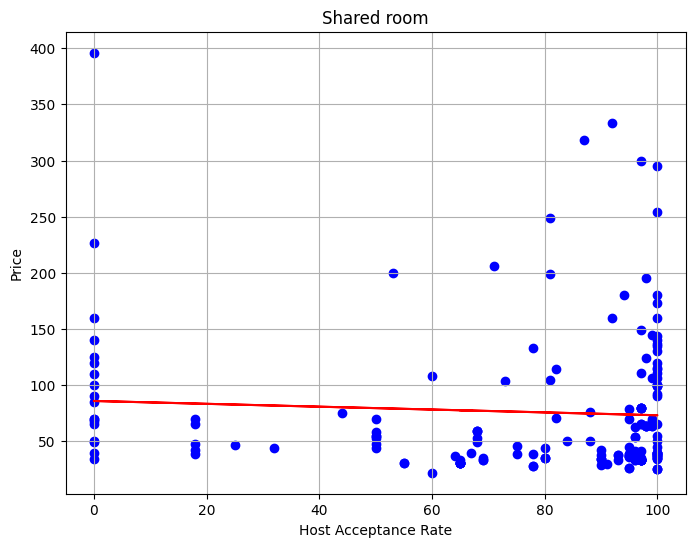

In [67]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['host_acceptance_rate']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['host_acceptance_rate']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['host_acceptance_rate']], model.predict(cd_shared[['host_acceptance_rate']]), color='red')
plt.title('Shared room')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [68]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['host_acceptance_rate']], cd_shared['price']))

Pendiente: [-0.12728277]
Intercepto: 85.89733156896064
y = -0.12728277150359738x + 85.89733156896064

Puntaje del modelo: 0.0040635236586586965


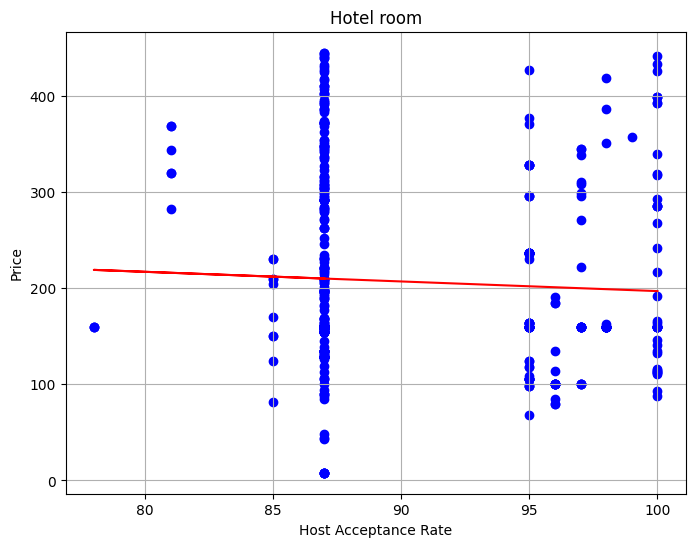

In [69]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['host_acceptance_rate']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['host_acceptance_rate']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['host_acceptance_rate']], model.predict(cd_hotel[['host_acceptance_rate']]), color='red')
plt.title('Hotel room')
plt.xlabel('Host Acceptance Rate')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [70]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['host_acceptance_rate']], cd_hotel['price']))

Pendiente: [-1.00385759]
Intercepto: 297.3573015759016
y = -1.0038575896452795x + 297.3573015759016

Puntaje del modelo: 0.002883782645606514


### x = host_is_superhost, y = price

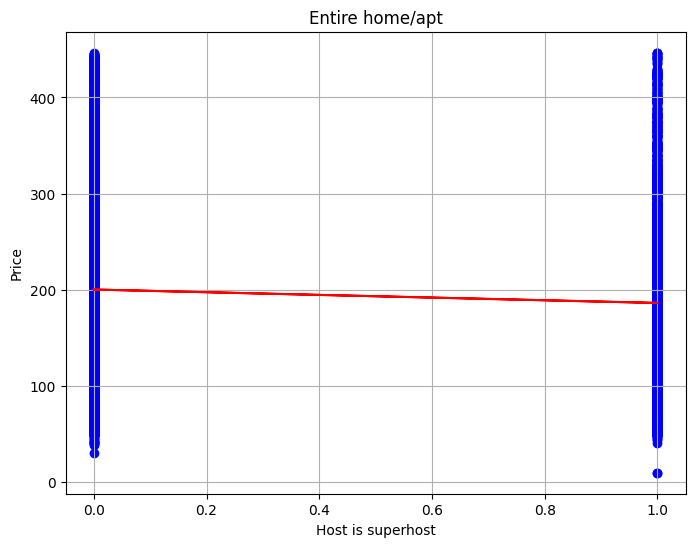

In [71]:
# Ahora, vamos a realizar una regresión lineal usando cada df de habitaciones con respecto al precio y host_is_superhost.

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['host_is_superhost']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['host_is_superhost']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['host_is_superhost']], model.predict(cd_entire[['host_is_superhost']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Host is superhost')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [72]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['host_is_superhost']], cd_entire['price']))

Pendiente: [-13.95244937]
Intercepto: 200.39080918564264
y = -13.95244937494541x + 200.39080918564264

Puntaje del modelo: 0.005347372637710013


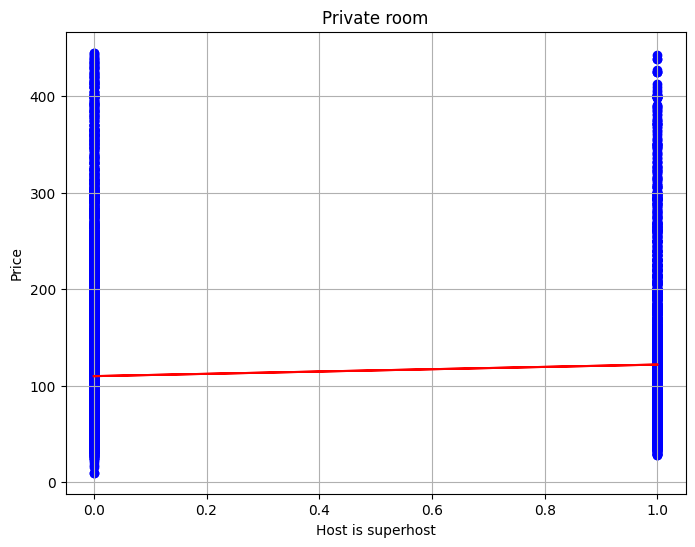

In [73]:
# Private room
model = LinearRegression()
model.fit(cd_private[['host_is_superhost']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['host_is_superhost']], cd_private['price'], color='blue')
plt.plot(cd_private[['host_is_superhost']], model.predict(cd_private[['host_is_superhost']]), color='red')
plt.title('Private room')
plt.xlabel('Host is superhost')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [74]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['host_is_superhost']], cd_private['price']))

Pendiente: [11.97262852]
Intercepto: 110.02381921619865
y = 11.97262851669077x + 110.02381921619865

Puntaje del modelo: 0.004605179224768441


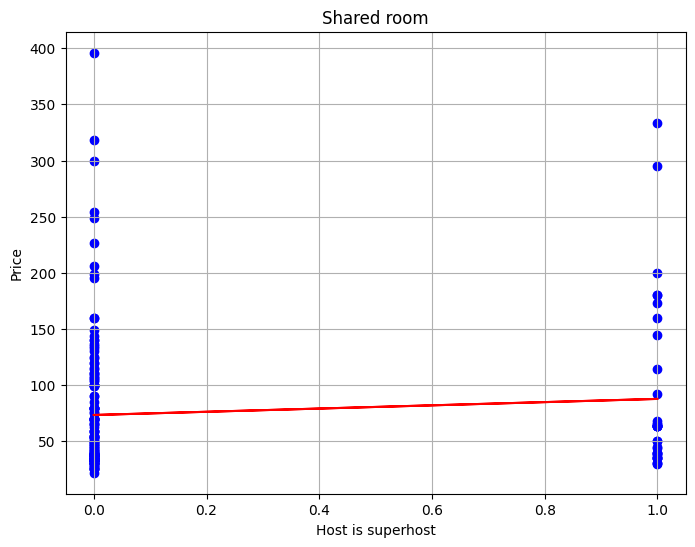

In [75]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['host_is_superhost']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['host_is_superhost']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['host_is_superhost']], model.predict(cd_shared[['host_is_superhost']]), color='red')
plt.title('Shared room')
plt.xlabel('Host is superhost')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [76]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['host_is_superhost']], cd_shared['price']))

Pendiente: [14.33620467]
y = 14.336204667297391x + 73.40093818984548

Puntaje del modelo: 0.007873190457873935


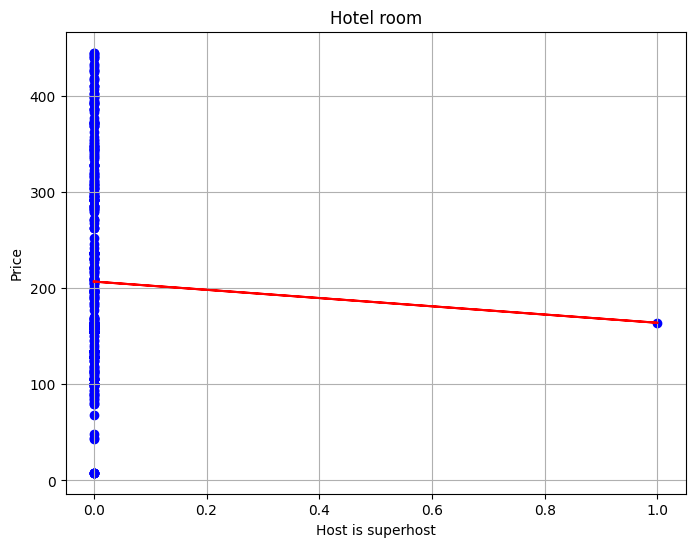

In [77]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['host_is_superhost']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['host_is_superhost']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['host_is_superhost']], model.predict(cd_hotel[['host_is_superhost']]), color='red')
plt.title('Hotel room')
plt.xlabel('Host is superhost')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [78]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['host_is_superhost']], cd_hotel['price']))

Pendiente: [-42.89761725]
Intercepto: 206.897617252029
y = -42.89761725202832x + 206.897617252029

Puntaje del modelo: 0.00040094354826569756


### x = bathrooms, y = accomodates

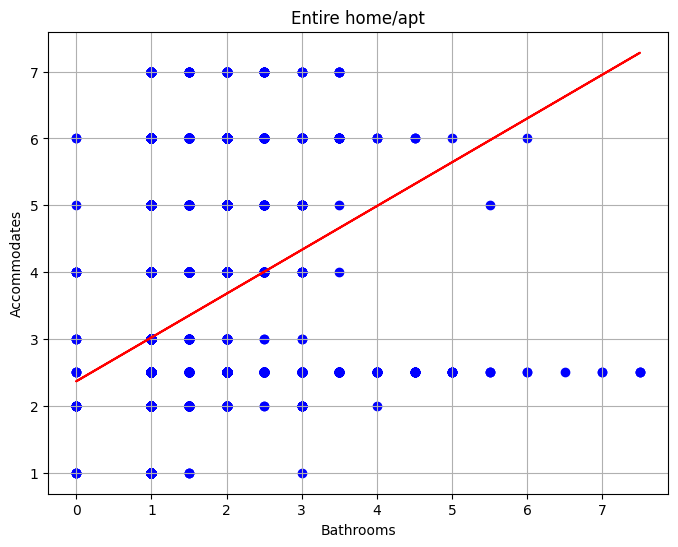

In [79]:
# Ahora, vamos a realizar una regresión lineal usando cada df de habitaciones con respecto al accoomodates y bathrooms.
# Ponemos los baños como variable independiente y el número de acomodados como variable dependiente.

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['bathrooms']], cd_entire['accommodates'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['bathrooms']], cd_entire['accommodates'], color='blue')
plt.plot(cd_entire[['bathrooms']], model.predict(cd_entire[['bathrooms']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [80]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['bathrooms']], cd_entire['accommodates']))

Pendiente: [0.65514385]
Intercepto: 2.3680616084180857
y = 0.6551438523602033x + 2.3680616084180857

Puntaje del modelo: 0.05886849064313193


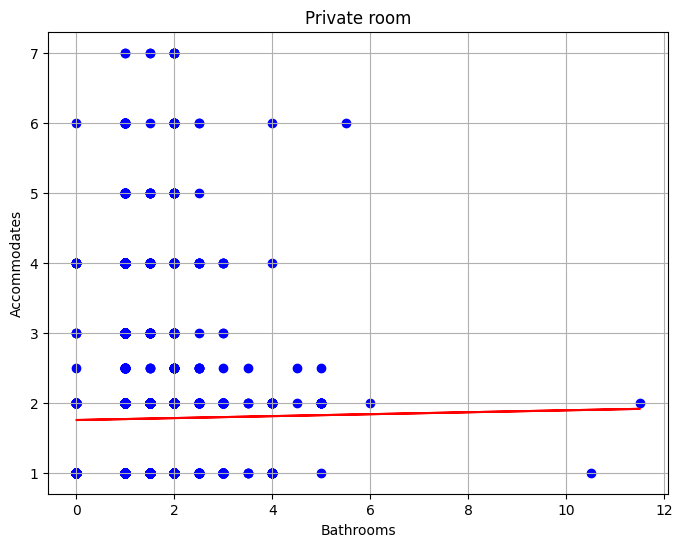

In [81]:
# Private room
model = LinearRegression()
model.fit(cd_private[['bathrooms']], cd_private['accommodates'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['bathrooms']], cd_private['accommodates'], color='blue')
plt.plot(cd_private[['bathrooms']], model.predict(cd_private[['bathrooms']]), color='red')
plt.title('Private room')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [82]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['bathrooms']], cd_private['accommodates']))

Pendiente: [0.01389936]
Intercepto: 1.7527571898243561
y = 0.013899361441146998x + 1.7527571898243561

Puntaje del modelo: 9.465814853293342e-05


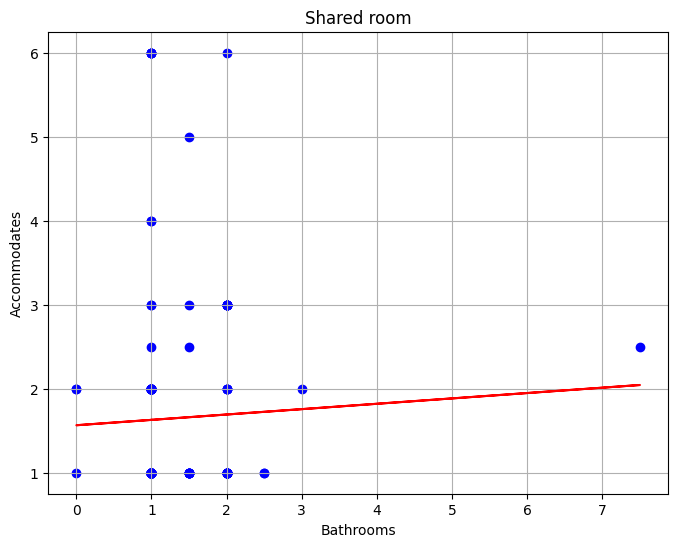

In [83]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['bathrooms']], cd_shared['accommodates'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['bathrooms']], cd_shared['accommodates'], color='blue')
plt.plot(cd_shared[['bathrooms']], model.predict(cd_shared[['bathrooms']]), color='red')
plt.title('Shared room')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [84]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['bathrooms']], cd_shared['accommodates']))

Pendiente: [0.06387975]
Intercepto: 1.5652522613397715
y = 0.06387974798670486x + 1.5652522613397715

Puntaje del modelo: 0.0015594801877728548


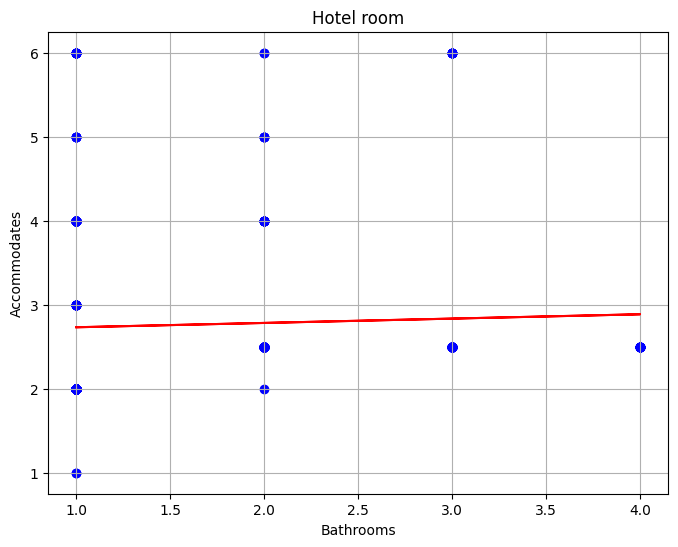

In [85]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['bathrooms']], cd_hotel['accommodates'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['bathrooms']], cd_hotel['accommodates'], color='blue')
plt.plot(cd_hotel[['bathrooms']], model.predict(cd_hotel[['bathrooms']]), color='red')
plt.title('Hotel room')
plt.xlabel('Bathrooms')
plt.ylabel('Accommodates')
plt.grid(True)
plt.show()

In [86]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['bathrooms']], cd_hotel['accommodates']))

Pendiente: [0.05153506]
Intercepto: 2.680056340414717
y = 0.05153506449494823x + 2.680056340414717

Puntaje del modelo: 0.001678120398136529


### x = review_score_cleanliness, y = price

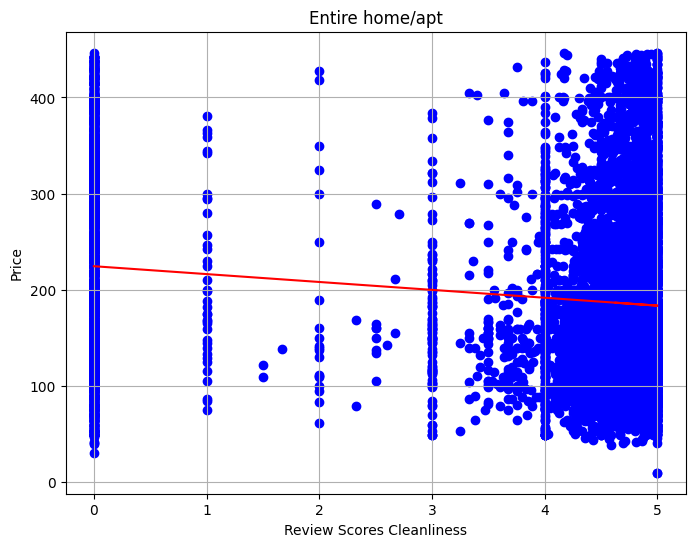

In [87]:
# Seguimos, pero ahora con review_score_cleanliness y price

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['review_scores_cleanliness']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['review_scores_cleanliness']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['review_scores_cleanliness']], model.predict(cd_entire[['review_scores_cleanliness']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [88]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['review_scores_cleanliness']], cd_entire['price']))

Pendiente: [-8.19444077]
y = -8.19444077170333x + 224.62641535222764

Puntaje del modelo: 0.036890446671605015


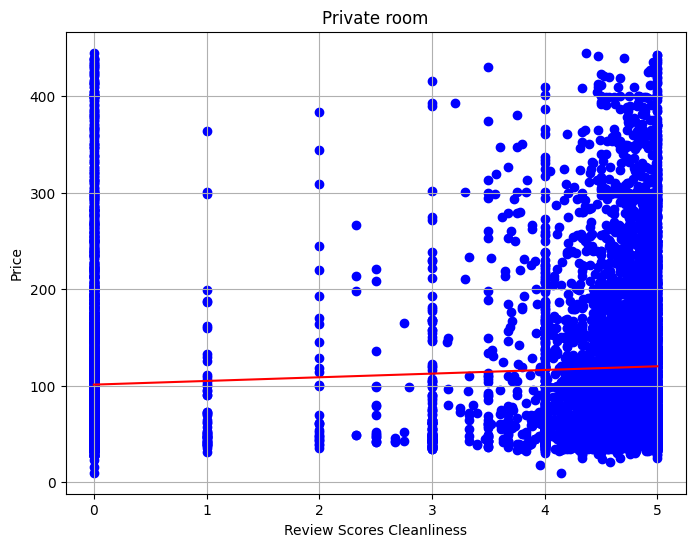

In [89]:
# Private room
model = LinearRegression()
model.fit(cd_private[['review_scores_cleanliness']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['review_scores_cleanliness']], cd_private['price'], color='blue')
plt.plot(cd_private[['review_scores_cleanliness']], model.predict(cd_private[['review_scores_cleanliness']]), color='red')
plt.title('Private room')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [90]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['review_scores_cleanliness']], cd_private['price']))

Pendiente: [3.79872271]
y = 3.798722708649531x + 101.24952977188177

Puntaje del modelo: 0.010933617034038279


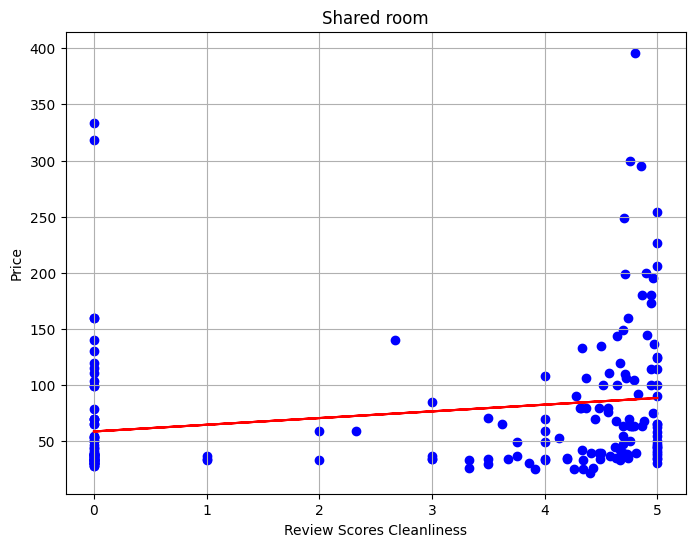

In [91]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['review_scores_cleanliness']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['review_scores_cleanliness']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['review_scores_cleanliness']], model.predict(cd_shared[['review_scores_cleanliness']]), color='red')
plt.title('Shared room')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [92]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['review_scores_cleanliness']], cd_shared['price']))

Pendiente: [5.96462251]
y = 5.964622507142897x + 58.73899418628996

Puntaje del modelo: 0.04187278725115018


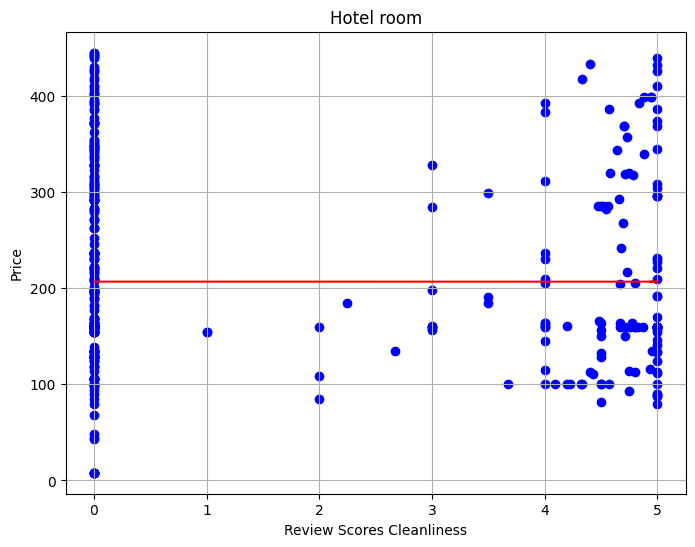

In [93]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['review_scores_cleanliness']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['review_scores_cleanliness']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['review_scores_cleanliness']], model.predict(cd_hotel[['review_scores_cleanliness']]), color='red')
plt.title('Hotel room')
plt.xlabel('Review Scores Cleanliness')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [94]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['review_scores_cleanliness']], cd_hotel['price']))

Pendiente: [-0.00768503]
Intercepto: 206.8240202045682
y = -0.0076850252067501715x + 206.8240202045682

Puntaje del modelo: 2.8937258811367883e-08


### host_idendity_verified, y = price

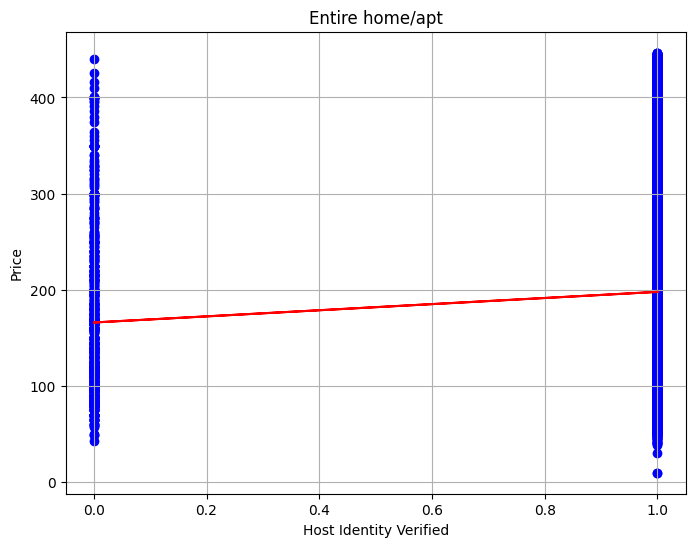

In [95]:
# Seguimos con host_identity_verified como independiente y price como dependiente

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['host_identity_verified']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['host_identity_verified']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['host_identity_verified']], model.predict(cd_entire[['host_identity_verified']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Host Identity Verified')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [96]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['host_identity_verified']], cd_entire['price']))

Pendiente: [31.82439154]
Intercepto: 166.1304829256752
y = 31.82439154451236x + 166.1304829256752

Puntaje del modelo: 0.007596477170287885


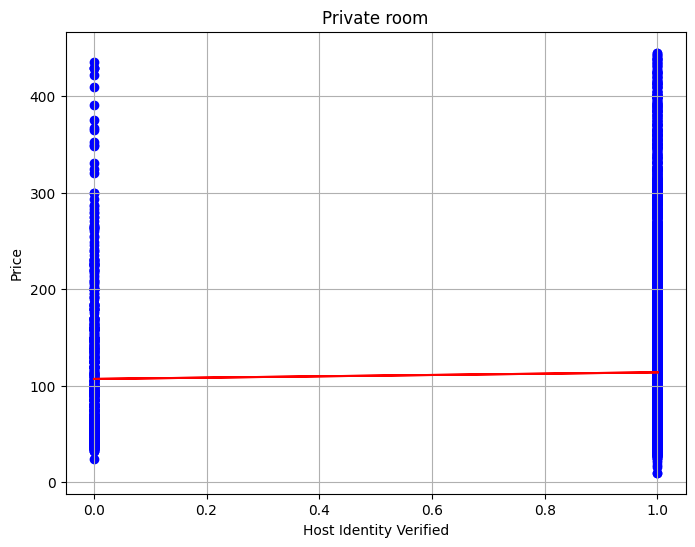

In [97]:
# Private room
model = LinearRegression()
model.fit(cd_private[['host_identity_verified']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['host_identity_verified']], cd_private['price'], color='blue')
plt.plot(cd_private[['host_identity_verified']], model.predict(cd_private[['host_identity_verified']]), color='red')
plt.title('Private room')
plt.xlabel('Host Identity Verified')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [98]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['host_identity_verified']], cd_private['price']))

Pendiente: [6.85068267]
Intercepto: 107.1205583248591
y = 6.850682668744481x + 107.1205583248591

Puntaje del modelo: 0.0005523813720689219


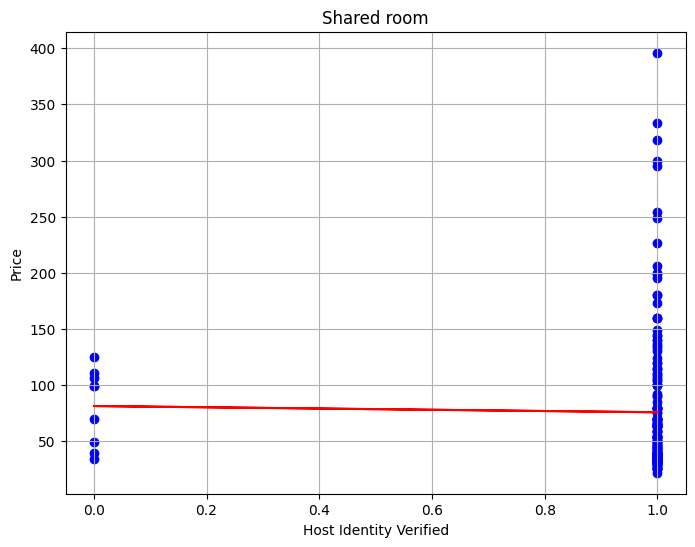

In [99]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['host_identity_verified']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['host_identity_verified']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['host_identity_verified']], model.predict(cd_shared[['host_identity_verified']]), color='red')
plt.title('Shared room')
plt.xlabel('Host Identity Verified')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [100]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['host_identity_verified']], cd_shared['price']))

Pendiente: [-5.55927495]
Intercepto: 81.38888888888889
y = -5.559274952919022x + 81.38888888888889

Puntaje del modelo: 0.00035685309261479503


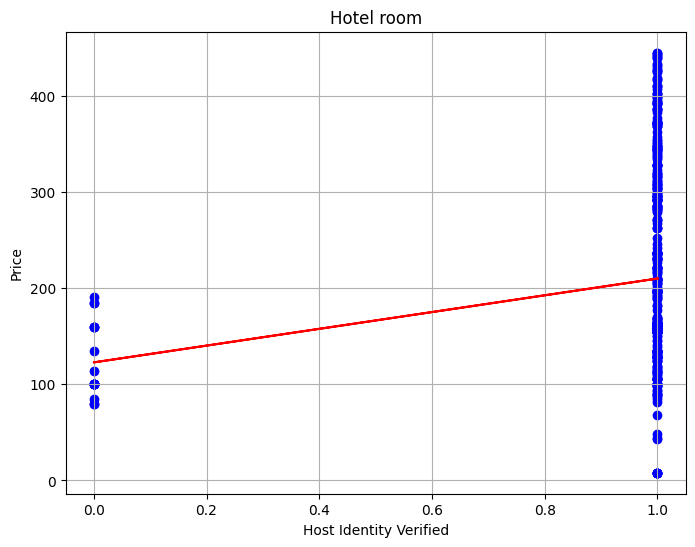

In [101]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['host_identity_verified']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['host_identity_verified']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['host_identity_verified']], model.predict(cd_hotel[['host_identity_verified']]), color='red')
plt.title('Hotel room')
plt.xlabel('Host Identity Verified')
plt.ylabel('Price')
plt.grid(True)
plt.show()


In [102]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['host_identity_verified']], cd_hotel['price']))

Pendiente: [87.24716636]
Intercepto: 122.81052631578933
y = 87.24716636415944x + 122.81052631578933

Puntaje del modelo: 0.030399614661050012


### x = instant_bookable, y = price

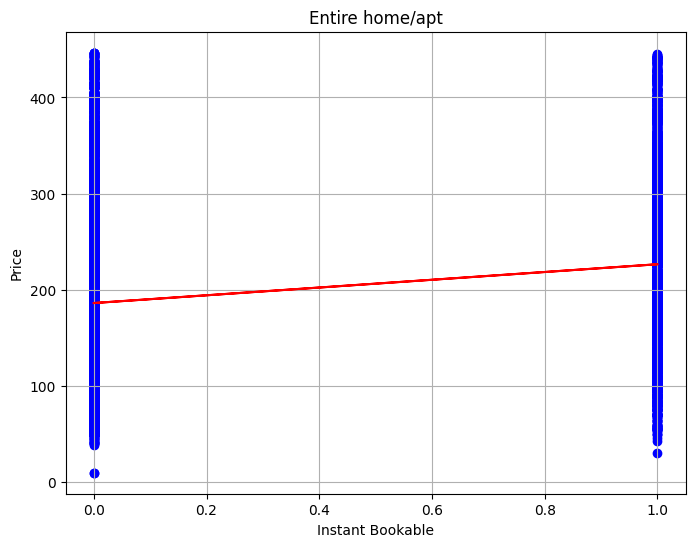

In [103]:
# Seguimos, pero ahora con instant_bookable y price

# Entire home/apt
model = LinearRegression()
model.fit(cd_entire[['instant_bookable']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['instant_bookable']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['instant_bookable']], model.predict(cd_entire[['instant_bookable']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [104]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['instant_bookable']], cd_entire['price']))

Pendiente: [40.33146226]
Intercepto: 186.33639974776864
y = 40.331462258504786x + 186.33639974776864

Puntaje del modelo: 0.03730869883551502


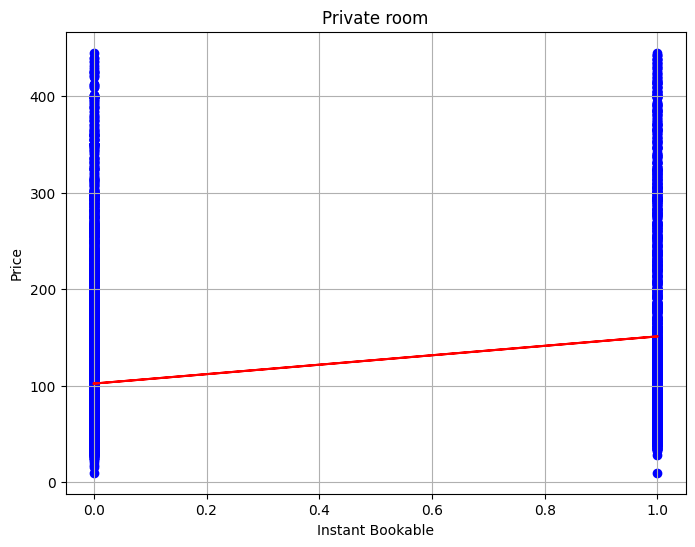

In [105]:
# Private room
model = LinearRegression()
model.fit(cd_private[['instant_bookable']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['instant_bookable']], cd_private['price'], color='blue')
plt.plot(cd_private[['instant_bookable']], model.predict(cd_private[['instant_bookable']]), color='red')
plt.title('Private room')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [106]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonce, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['instant_bookable']], cd_private['price']))

Pendiente: [48.88751942]
Intercepto: 102.31625692172528
y = 48.88751941635374x + 102.31625692172528

Puntaje del modelo: 0.06635730647208615


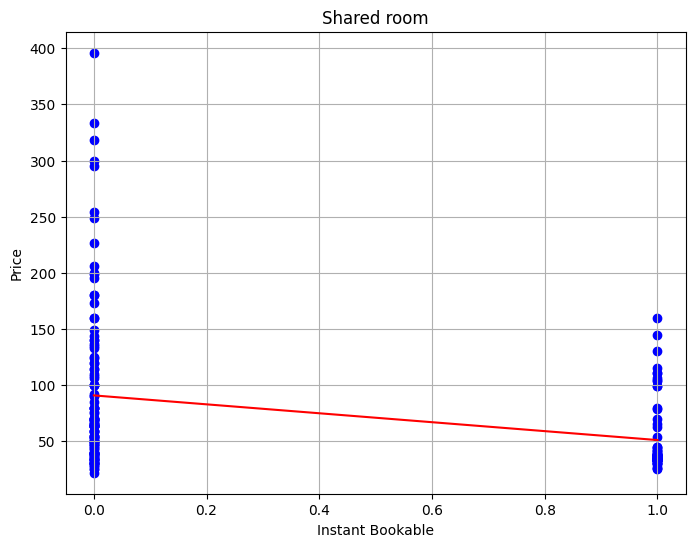

In [107]:
# Shared room
model = LinearRegression()
model.fit(cd_shared[['instant_bookable']], cd_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['instant_bookable']], cd_shared['price'], color='blue')
plt.plot(cd_shared[['instant_bookable']], model.predict(cd_shared[['instant_bookable']]), color='red')
plt.title('Shared room')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [108]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_shared[['instant_bookable']], cd_shared['price']))

Pendiente: [-39.7667255]
Intercepto: 90.85078347578346
y = -39.76672550476896x + 90.85078347578346

Puntaje del modelo: 0.09253627142121013


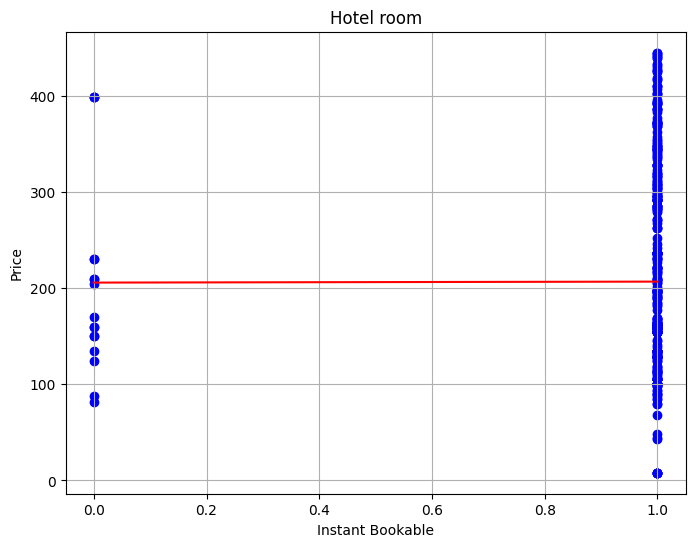

In [109]:
# Hotel room
model = LinearRegression()
model.fit(cd_hotel[['instant_bookable']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['instant_bookable']], cd_hotel['price'], color='blue')
plt.plot(cd_hotel[['instant_bookable']], model.predict(cd_hotel[['instant_bookable']]), color='red')
plt.title('Hotel room')
plt.xlabel('Instant Bookable')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [110]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_hotel[['instant_bookable']], cd_hotel['price']))

Pendiente: [1.02247459]
Intercepto: 205.82521008403344
y = 1.0224745862220828x + 205.82521008403344

Puntaje del modelo: 3.750832137328075e-06


### x = property_type, y = price

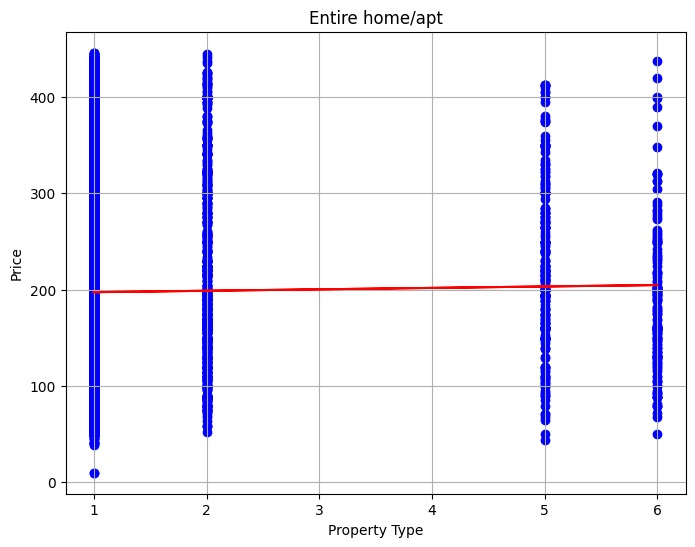

In [111]:
# Hacemos lo mismo, pero ahora con property_type y price

# Entire home/apt
model = LinearRegression()

# Filtramos ny_entire para quitar todos los valores en los que property_type no sea numérico
cd_entire = cd_entire[pd.to_numeric(cd_entire['property_type'], errors='coerce').notnull()]

model.fit(cd_entire[['property_type']], cd_entire['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_entire[['property_type']], cd_entire['price'], color='blue')
plt.plot(cd_entire[['property_type']], model.predict(cd_entire[['property_type']]), color='red')
plt.title('Entire home/apt')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [112]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_entire[['property_type']], cd_entire['price']))

Pendiente: [1.48382714]
Intercepto: 195.91957756720535
y = 1.4838271415674817x + 195.91957756720535

Puntaje del modelo: 0.00023237022081090686


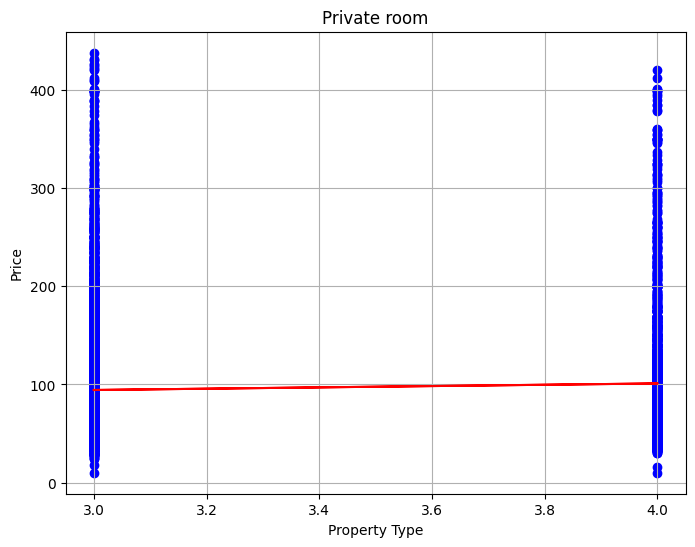

In [113]:
# Private room
model = LinearRegression()
cd_private = cd_private[pd.to_numeric(cd_private['property_type'], errors='coerce').notnull()]
model.fit(cd_private[['property_type']], cd_private['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_private[['property_type']], cd_private['price'], color='blue')
plt.plot(cd_private[['property_type']], model.predict(cd_private[['property_type']]), color='red')
plt.title('Private room')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()

In [114]:
# Obtenemos los parámetros
m = model.coef_
b = model.intercept_
print('Pendiente:', m)
print('Intercepto:', b)

# Entonces, el modelo lineal sería:
print(f'y = {m[0]}x + {b}', end='\n\n')

print('Puntaje del modelo:', model.score(cd_private[['property_type']], cd_private['price']))

Pendiente: [6.69453159]
Intercepto: 74.20633834759235
y = 6.694531587563798x + 74.20633834759235

Puntaje del modelo: 0.0021303721091190386


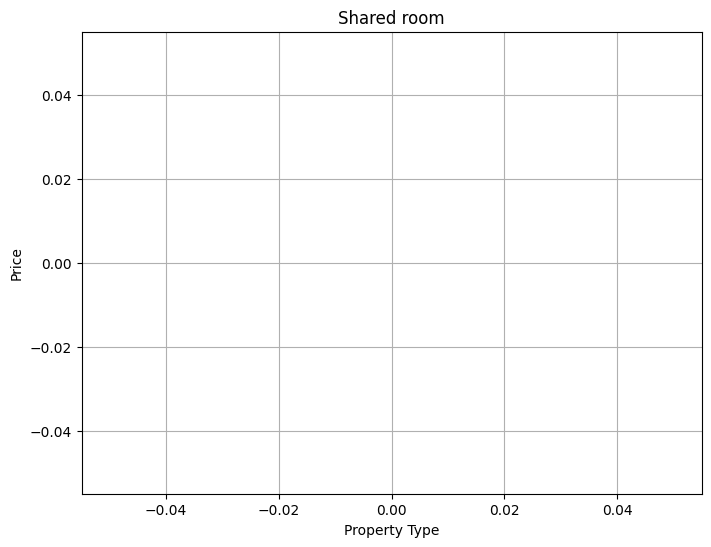

In [115]:
# Shared room
model = LinearRegression()
cd_shared = cd_shared[pd.to_numeric(cd_shared['property_type'], errors='coerce').notnull()]
#model.fit(ny_shared[['property_type']], ny_shared['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_shared[['property_type']], cd_shared['price'], color='blue')
#plt.plot(ny_shared[['property_type']], model.predict(ny_shared[['property_type']]), color='red')
plt.title('Shared room')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Paraece que ninguna de las habitaciones compartidas tiene property_type de los 6 más comunes

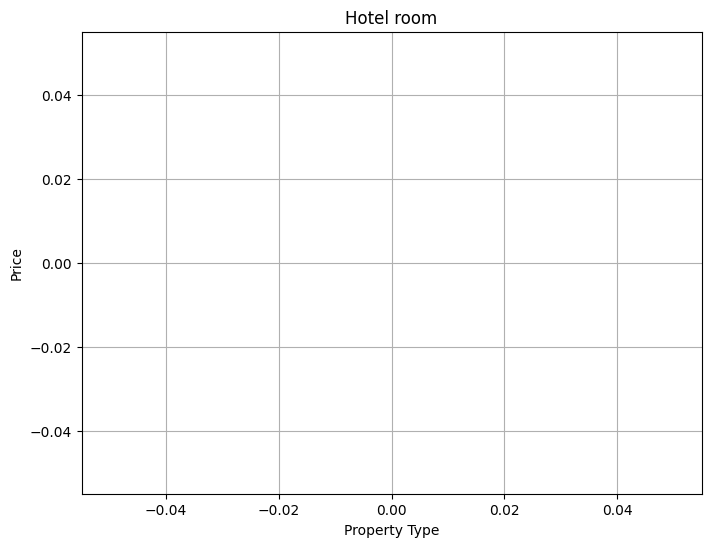

In [116]:
# Hotel room
model = LinearRegression()
cd_hotel = cd_hotel[pd.to_numeric(cd_hotel['property_type'], errors='coerce').notnull()]
#model.fit(cd_hotel[['property_type']], cd_hotel['price'])
plt.figure(figsize=(8, 6))
plt.scatter(cd_hotel[['property_type']], cd_hotel['price'], color='blue')
#plt.plot(cd_hotel[['property_type']], model.predict(cd_hotel[['property_type']]), color='red')
plt.title('Hotel room')
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.grid(True)
plt.show()
# Parece que ninguna de las habitaciones tiene un tipo de propiedad de las 6 más comunes

In [117]:
# # Obtenemos los parámetros
# m = model.coef_
# b = model.intercept_
# print('Pendiente:', m)
# print('Intercepto:', b)

# # Entonces, el modelo lineal sería:
# print(f'y = {m[0]}x + {b}', end='\n\n')

# print('Puntaje del modelo:', model.score(cd_hotel[['property_type']], cd_hotel['price']))

## Tablas